In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import os
import matplotlib.style
from pandas.core.common import flatten
from functools import partial, reduce

In [2]:
import sys
sys.path.append('../../')

In [3]:
from config.constants import *

In [4]:
plt.style.use('ggplot')

In [5]:
pairs_list = [
    'XAUUSD/XAUUSD_H4 - XAUUSD_H4',
]

In [6]:
df = {}
for pair in range(len(pairs_list)):
    df[pair] = pd.read_csv(PATH_DATA + SYMBOL['XAUUSD']['H4'] + '.csv', index_col='Time', parse_dates=True)

In [7]:
#Strategy parameters
account_size = 1000
slippage = 2
size = 1
ATR_SL = 0.5

In [8]:
def average_bar_size(df):
    df = df.copy()
    df['candle_size'] = df['High'] - df['Low']
    df['average_bar'] = df['candle_size'].rolling(20).mean()
    return df

def small_wick(df, wick_size):
    df = df.copy()
    df['small_wick'] = np.where((df['Close'] > df['Open']) \
                               & ((df['High'] - df['Close']) <= ((df['High'] - df['Low']) * wick_size)) \
                               & ((df['Open'] - df['Low']) <= ((df['High'] - df['Low']) * wick_size)) \
                               | (df['Close'] < df['Open']) \
                               & ((df['High'] - df['Open']) <= ((df['High'] - df['Low']) * wick_size)) \
                               & ((df['Close'] - df['Low']) <= ((df['High'] - df['Low']) * wick_size)), True, False)
    return df

def ATR(df, n):
    df = df.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis = 1, skipna = False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose'], axis = 1)
    return df

def CAGR(df, source_df):
    df = df.copy()
    n = len(source_df) / (252*24)
    return round((((df['cum_res'][-1] / account_size)**(1/n)) - 1) * 100, 1)

def sharpe_ratio(df):
    df = df.copy()
    returns = df['cum_res'].pct_change()
    volatility = returns.std() * np.sqrt(252)
    return round((returns.mean() - 0.02) / volatility, 2)

def max_drawdown(df):
    df = df.copy()
    cum_returns = (1 + df['cum_res']).cumprod()
    drawdown = 1 - df['cum_res'].div(df['cum_res'].cummax())
    return round(max(drawdown.expanding().max() * 100), 2)

In [9]:


for pair in range(len(pairs_list)):
    df[pair]['ATR'] = ATR(df[pair], 20)['ATR']
    df[pair]['average_bar'] = average_bar_size(df[pair])['average_bar']
    df[pair]['small_wick'] = small_wick(df[pair], 0.2)['small_wick']
    if 'USDJPY/USDJPY_H4 - USDJPY_H4'  not in pairs_list[pair] and 'XAUUSD/XAUUSD_H4 - XAUUSD_H4'  not in pairs_list[pair] :
        df[pair]['spread'] = float(slippage) / float(10000)
        df[pair]['size'] = float(size) * float(10000)
        print('Pair: ', pairs_list[pair], 'a')
    else:
        df[pair]['spread'] = float(slippage) / float(100)
        df[pair]['size'] = float(size) * float(100)
        print('Pair: ', pairs_list[pair], 'b')

Pair:  XAUUSD/XAUUSD_H4 - XAUUSD_H4 b


In [10]:
df[0].tail(20)

,Open,High,Low,Close,Volume,ATR,average_bar,small_wick,spread,size
Time,,,,,,,,,,
2023-03-07 12:00:00,1841.865,1841.865,1815.555,1817.905,240,7.31790,7.29270,True,0.02,100.0
2023-03-07 16:00:00,1817.705,1823.038,1812.655,1813.835,240,7.39205,7.36685,False,0.02,100.0
2023-03-07 20:00:00,1813.855,1815.915,1812.795,1813.865,180,7.23010,7.20490,False,0.02,100.0
2023-03-08 00:00:00,1813.855,1814.045,1809.248,1809.688,240,7.30745,7.28225,True,0.02,100.0
2023-03-08 04:00:00,1809.688,1814.925,1809.688,1814.135,240,7.38130,7.35610,True,0.02,100.0
2023-03-08 08:00:00,1814.125,1816.555,1812.265,1814.955,240,7.25280,7.22760,False,0.02,100.0
2023-03-08 12:00:00,1814.965,1824.185,1812.065,1820.555,240,7.53430,7.50960,False,0.02,100.0
2023-03-08 16:00:00,1820.588,1821.765,1813.235,1816.195,240,7.47830,7.45360,False,0.02,100.0
2023-03-08 20:00:00,1816.215,1816.285,1812.768,1815.175,179,7.15930,7.13460,False,0.02,100.0


In [11]:
open_trade = {}
trade = {}
long_take_profit = {}
short_take_profit = {}
long_stop_loss = {}
short_stop_loss = {}
long_entry_price = {}
short_entry_price = {}

for pair in range(len(pairs_list)):
    open_trade[pair] = []
    trade[pair] = {}
    long_take_profit[pair] = []
    short_take_profit[pair] = []
    long_stop_loss[pair] = []
    short_stop_loss[pair] = []
    long_entry_price[pair] = []
    short_entry_price[pair] = []
    
    for i in range(50, len(df[pair])):
        #Buy
        if (df[pair]['High'][i - 1] - df[pair]['Low'][i - 1]) >= 4 * df[pair]['average_bar'][i - 1] and df[pair]['small_wick'][i - 1] == True \
            and df[pair]['Close'][i - 1] > df[pair]['Open'][i - 1] and len(open_trade[pair]) == 0:
            print(i, 'New Long trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                             'date_of_trade': df[pair].index[i],
                             'entry_price': df[pair]['Close'][i],
                             'signal': 'Buy',
                             'result': 0, 
                             'TP': df[pair]['Close'][i] + df[pair]['ATR'][i] * 4 * ATR_SL,
                             'SL': df[pair]['Close'][i] - df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
        
        #Sell
        if (df[pair]['High'][i - 1] - df[pair]['Low'][i - 1]) >= 4 * df[pair]['average_bar'][i - 1] and df[pair]['small_wick'][i - 1] == True \
            and df[pair]['Close'][i - 1] < df[pair]['Open'][i - 1] and len(open_trade[pair]) == 0:
            print(i, 'New Short trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                             'date_of_trade': df[pair].index[i],
                             'entry_price': df[pair]['Close'][i],
                             'signal': 'Sell',
                             'result': 0, 
                             'TP': df[pair]['Close'][i] - df[pair]['ATR'][i] * 4 * ATR_SL,
                             'SL': df[pair]['Close'][i] + df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            short_take_profit[pair].append(trade[pair][i]['TP'])
            short_stop_loss[pair].append(trade[pair][i]['SL'])
            short_entry_price[pair].append(trade[pair][i]['entry_price'])
            
        #Exit trades---------------------------------------------------------------------------
        #Buy profit
        if any(y <= df[pair]['Close'][i] for y in long_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] >= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['TP'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Long profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Buy loss
        if any(y >= df[pair]['Close'][i] for y in long_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] <= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['SL'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Long loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
                        
        #Sell profit
        if any(y >= df[pair]['Close'][i] for y in short_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] <= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['TP'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Short profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Sell loss
        if any(y <= df[pair]['Close'][i] for y in short_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] >= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['SL'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Short loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Exit after time
        if len(open_trade[pair]) != 0:
            for j in open_trade[pair]:
                if (i - trade[pair][j]['ID']) >= 12 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    trade[pair][j].update({'result' : (df[pair]['Close'][i] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                    print(j, 
                         'Long exited after 12 hours:', round(df[pair]['Close'][i], 4),
                         'On day:', df[pair].index[i],
                         'With profit:', round(trade[pair][j]['result'], 4), '\n')
                    open_trade[pair].remove(j)
                    long_take_profit[pair].remove(trade[pair][j]['TP'])
                    long_stop_loss[pair].remove(trade[pair][j]['SL'])
                elif (i - trade[pair][j]['ID']) >= 12 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - df[pair]['Close'][i] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                    print(j, 
                         'Short exited after 12 hours:', round(df[pair]['Close'][i], 4),
                         'On day:', df[pair].index[i],
                         'With profit:', round(trade[pair][j]['result'], 4), '\n')
                    open_trade[pair].remove(j)
                    short_take_profit[pair].remove(trade[pair][j]['TP'])
                    short_stop_loss[pair].remove(trade[pair][j]['SL'])

234 New Long trade at price: 677.559  On day: 2007-02-21 20:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
234 Long loss at price: 674.574 On day: 2007-02-22 20:00:00 With loss: -226.23 

989 New Long trade at price: 672.62  On day: 2007-08-10 16:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
989 Long loss at price: 670.401 On day: 2007-08-12 20:00:00 With loss: -222.1825 

1014 New Short trade at price: 652.82  On day: 2007-08-16 16:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
1014 Short loss at price: 657.198 On day: 2007-08-17 12:00:00 With loss: -211.525 

1107 New Long trade at price: 695.416  On day: 2007-09-06 16:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
1107 Long loss at price: 692.791 On day: 2007-09-07 00:00:00 With loss: -164.94 

2775 New Long trade at price: 866.563  On day: 2008-09-17 16:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
2775 Long loss at price: 856.363 On day: 2008-09-18 00:00:00 With loss: -689.5075 



3222 New Long trade at price: 867.057  On day: 2008-12-26 20:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
3222 Long profit at price: 883.832 On day: 2008-12-29 00:00:00 With profit: 1172.06 

3582 New Long trade at price: 935.251  On day: 2009-03-18 20:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
3582 Long loss at price: 928.832 On day: 2009-03-19 00:00:00 With loss: -497.0525 

4707 New Short trade at price: 1162.936  On day: 2009-11-27 08:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
4707 Short loss at price: 1174.607 On day: 2009-11-27 12:00:00 With loss: -520.0125 

5013 New Short trade at price: 1064.467  On day: 2010-02-04 16:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
5013 Short exited after 12 hours: 1069.052 On day: 2010-02-08 12:00:00 With profit: -460.5 

6055 New Long trade at price: 1308.254  On day: 2010-09-28 16:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
6055 Long loss at price: 1302.325 On day: 2010-09-30 12:00:00 With loss: -254.14 

6489 New Short trade at price: 1380.226  On day: 2011

In [12]:
pairs_results = {}
profits = {}
losses = {}
be = {}

for pair in range(len(pairs_list)):
    profits[pair] = []
    losses[pair] = []
    be[pair] = []
    
    pairs_results[pair] = pd.DataFrame.from_dict({(i, j): trade[pair][j] for j in trade[pair].keys()}, orient = 'index')
    pairs_results[pair] = pairs_results[pair].drop(['signal', 'ID', 'TP', 'SL'], axis = 1)
    pairs_results[pair].set_index('date_of_trade', inplace = True)
    pairs_results[pair]['cum_res'] = pairs_results[pair]['result'].cumsum() + account_size
    
    for t in trade[pair]:
        profits[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] > 0.1 else ''
        losses[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] < -0.1 else ''
        be[pair].append(trade[pair][t]['result']) if -0.1 <= trade[pair][t]['result'] <= 0.1 else ''
        
my_reduce = partial(pd.merge, on = 'date_of_trade', how = 'outer')
strategy_results = reduce(my_reduce, pairs_results.values())
strategy_results = strategy_results.sort_index()
strategy_results['final_res'] = strategy_results.filter(like = 'result', axis = 1).sum(axis = 1)
strategy_results['cum_res'] = strategy_results['final_res'].cumsum() + account_size

profits_keys = list(profits.keys())
profits_values = [profits[x] for x in profits_keys]
str_profits = list(flatten(profits_values))

losses_keys = list(losses.keys())
losses_values = [losses[x] for x in losses_keys]
str_losses = list(flatten(losses_values))

be_keys = list(be.keys())
be_values = [be[x] for x in be_keys]
str_be = list(flatten(be_values))

Text(0.5, 1.0, 'Returns of each pair')

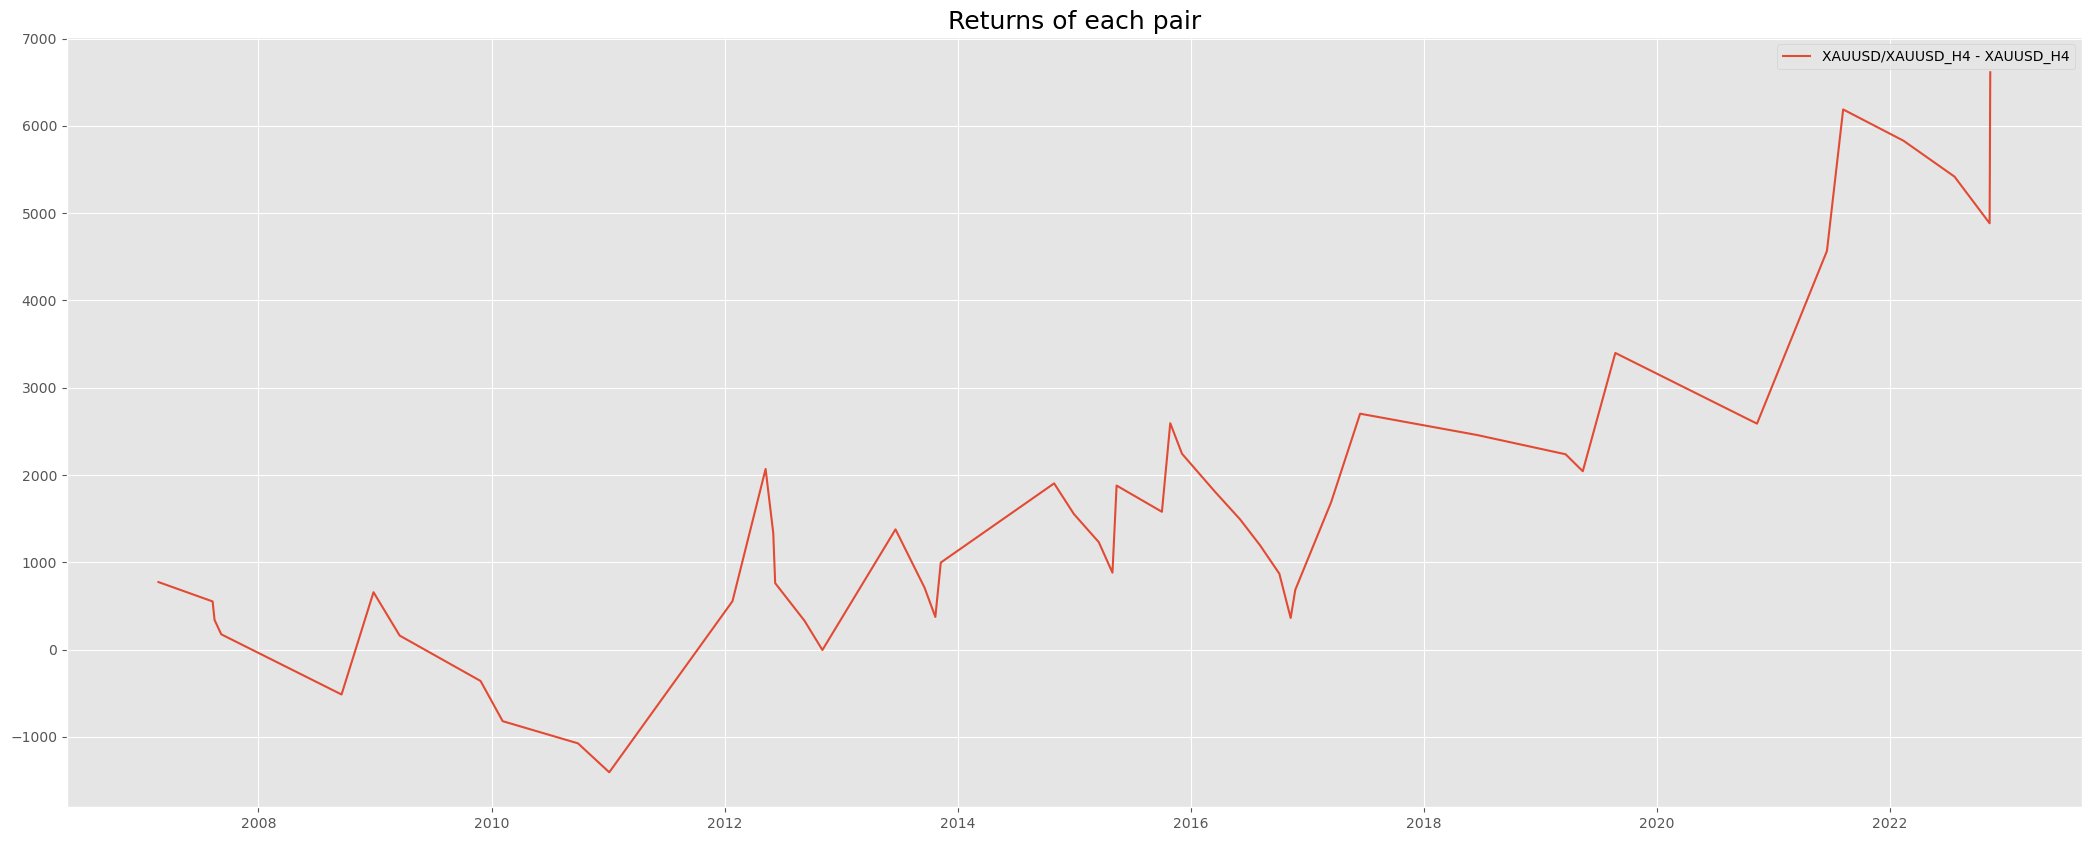

In [13]:
plt.figure(figsize = (26, 10))
for pair in range(len(pairs_list)):
    plt.plot(pairs_results[pair]['cum_res'], label = pairs_list[pair])
plt.legend()
plt.title('Returns of each pair', fontsize = 18)

***** STRATEGY PERFORMANCE *****
--------------------------------
CAGR: 55.2 %
Sharpe ratio: -0.01
Maximum drawdown 281.63 % 

Number of trades: 48
Number of profits: 15
Number of losses: 33
Number of breakevens: 0 

Winning percentage 31.25 %
ROI: 5614
--------------------------------
Average profitable trade: 1239.77
Average lossing trade: -393.42
Max profitable trade: 1978.2
Max lossing trade: -809.84


Text(0.5, 1.0, 'return of strategy')

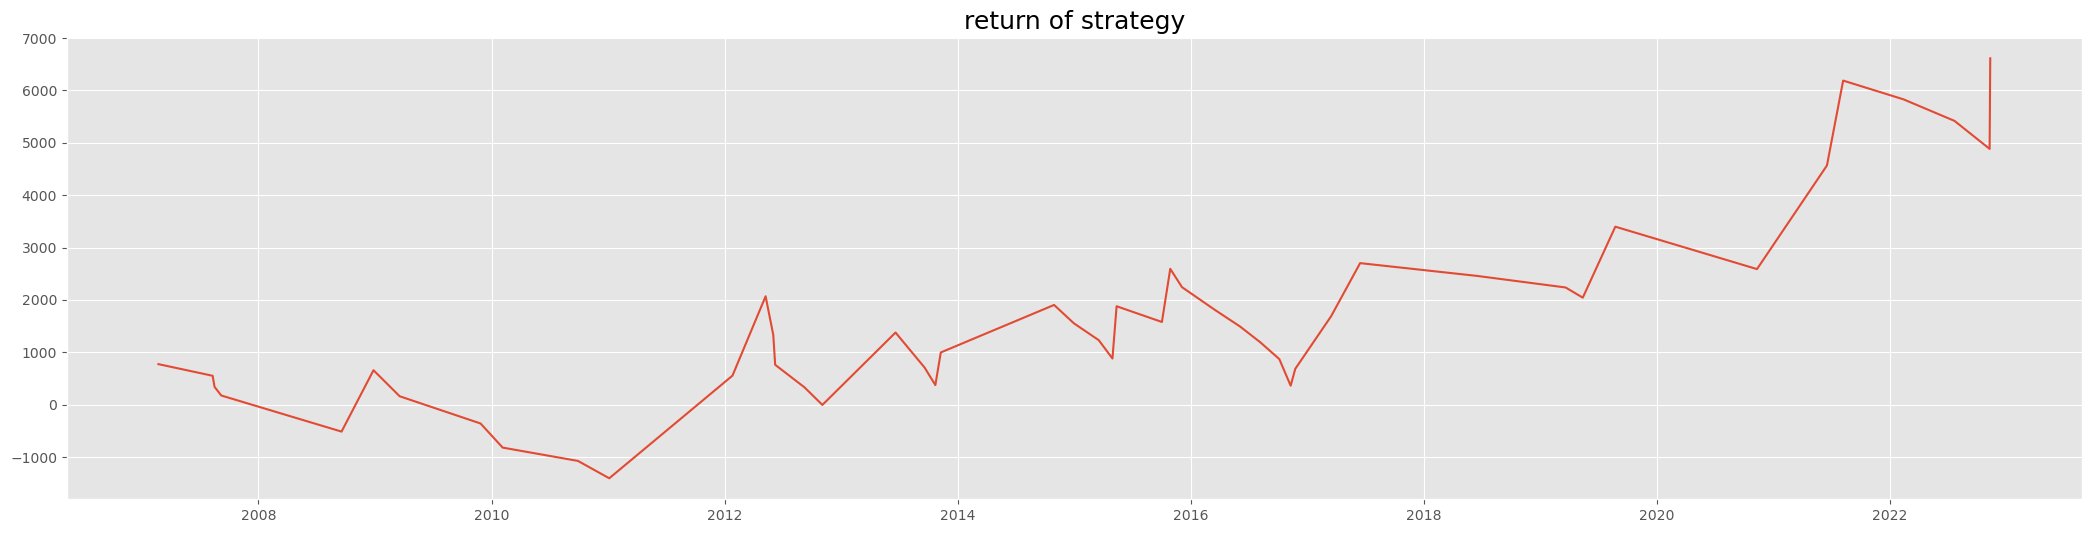

In [14]:
#Strategy performance
print('***** STRATEGY PERFORMANCE *****')
print('--------------------------------')
print('CAGR:', CAGR(strategy_results, df[0]), '%')
print('Sharpe ratio:', sharpe_ratio(strategy_results))
print('Maximum drawdown', max_drawdown(strategy_results), '% \n')
print('Number of trades:', len(str_profits + str_losses + str_be))
print('Number of profits:', len(str_profits))
print('Number of losses:', len(str_losses))
print('Number of breakevens:', len(str_be), '\n')
print('Winning percentage', (round(len(str_profits) / (len(str_profits) + len(str_losses)) * 100, 2)), '%')
print('ROI:', round(strategy_results['cum_res'][-1]) - account_size)
print('--------------------------------')
print('Average profitable trade:', round(sum(str_profits) / len(str_profits), 2))
print('Average lossing trade:', round(sum(str_losses) / len(str_losses), 2))
print('Max profitable trade:', round(max(str_profits), 2))
print('Max lossing trade:', round(min(str_losses), 2))

plt.figure(figsize = (26, 6))
plt.plot(strategy_results['cum_res'])
plt.title('return of strategy', fontsize = 18)

In [15]:
#performance for each pair
for pair in range(len(pairs_list)):
    print(pairs_list[pair], '- PERFORMANCE')
    print('--------------------------------')
    print('Number of trades:', len(profits[pair] + losses[pair] + be[pair]))
    print('Number of profits:', len(profits[pair]))
    print('Number of losses:', len(losses[pair]))
    print('Number of breakevens:', len(be[pair]), '\n')
    print('Winning percentage', (round(len(profits[pair]) / (len(profits[pair]) + len(losses[pair])) * 100, 2)), '%')
    print('ROI:', round(pairs_results[pair]['cum_res'][-1] - account_size, 2))
    print('--------------------------------')
    print('Average profitable trade:', round(sum(profits[pair]) / len(profits[pair]), 2))
    print('Average lossing trade:', round(sum(losses[pair]) / len(losses[pair]), 2))
    print('Max profitable trade:', round(max(profits[pair]), 2))
    print('Max lossing trade:', round(min(losses[pair]), 2))
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx \n')

XAUUSD/XAUUSD_H4 - XAUUSD_H4 - PERFORMANCE
--------------------------------
Number of trades: 48
Number of profits: 15
Number of losses: 33
Number of breakevens: 0 

Winning percentage 31.25 %
ROI: 5613.61
--------------------------------
Average profitable trade: 1239.77
Average lossing trade: -393.42
Max profitable trade: 1978.2
Max lossing trade: -809.84
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

